In [2]:
%%writefile src/signals/crossover.py
import pandas as pd

def ma_crossover_position(price: pd.Series, fast: int = 50, slow: int = 200) -> pd.Series:
    """
    1 when MA(fast) > MA(slow)
    0 otherwise
    """
    ma_fast = price.rolling(fast).mean()
    ma_slow = price.rolling(slow).mean()
    pos = (ma_fast > ma_slow).astype(int)
    pos.name = f"pos_ma_{fast}_{slow}"
    return pos

Writing src/signals/crossover.py


In [3]:
from src.signals.crossover import ma_crossover_position

In [5]:
import sys
sys.path.insert(0, ".")

import pandas as pd
import matplotlib.pyplot as plt

from src.signals.trend import ma_trend_position
from src.backtest.vectorized import long_flat_backtest
from src.performance.metrics import perf_stats, equity_curve
from src.signals.crossover import ma_crossover_position

In [6]:
sp500 = pd.read_csv("data/raw/sp500_fred.csv", parse_dates=["date"], index_col="date")
sp500 = sp500.rename(columns={"value": "price"}).dropna()
sp500["ret"] = sp500["price"].pct_change()

In [7]:
# 200 MA filter
pos_trend = ma_trend_position(sp500["price"], lookback=200)
bt_trend = long_flat_backtest(sp500["ret"], pos_trend, cost_bps=10)

# 50/200 crossover
pos_cross = ma_crossover_position(sp500["price"], fast=50, slow=200)
bt_cross = long_flat_backtest(sp500["ret"], pos_cross, cost_bps=10)

Trend 200: {'Obs': 2514, 'Total Return': 1.0258142460004174, 'CAGR': 0.07332967373934074, 'Vol': 0.11417309531450483, 'Sharpe': 0.6772746811515524, 'Max Drawdown': -0.21260860436173024}
Crossover 50/200: {'Obs': 2514, 'Total Return': 1.0106527458208006, 'CAGR': 0.07252173635270598, 'Vol': 0.14846853649013605, 'Sharpe': 0.5462631590536198, 'Max Drawdown': -0.33924959024260604}
Buy & Hold: {'Obs': 2514, 'Total Return': 2.5600730761865718, 'CAGR': 0.13573629372100404, 'Vol': 0.1799372043595087, 'Sharpe': 0.7978326455776024, 'Max Drawdown': -0.33924959024260615}


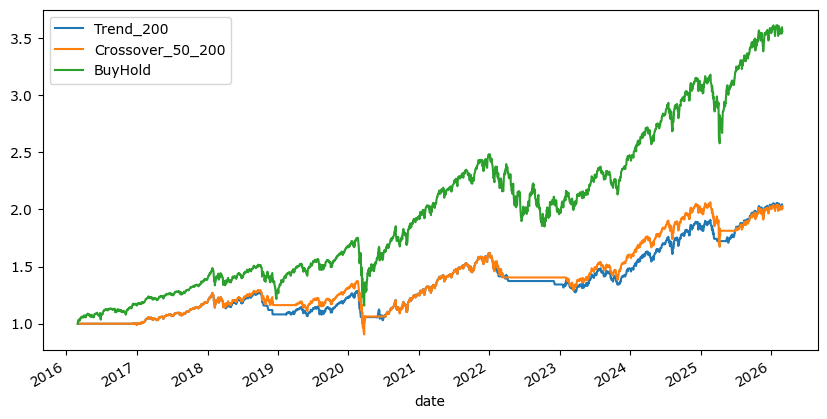

In [8]:
stats_trend = perf_stats(bt_trend["strategy_ret_net"])
stats_cross = perf_stats(bt_cross["strategy_ret_net"])
stats_bh = perf_stats(sp500["ret"])

print("Trend 200:", stats_trend)
print("Crossover 50/200:", stats_cross)
print("Buy & Hold:", stats_bh)

curve_trend = equity_curve(bt_trend["strategy_ret_net"])
curve_cross = equity_curve(bt_cross["strategy_ret_net"])
curve_bh = equity_curve(sp500["ret"])

pd.DataFrame({
    "Trend_200": curve_trend,
    "Crossover_50_200": curve_cross,
    "BuyHold": curve_bh
}).dropna().plot(figsize=(10,5))
plt.show()

In [9]:
%%writefile src/backtest/runner.py
import pandas as pd
from typing import Callable, Dict

from src.backtest.vectorized import long_flat_backtest
from src.performance.metrics import perf_stats, equity_curve

def run_strategy(
    price: pd.Series,
    returns: pd.Series,
    signal_fn: Callable[..., pd.Series],
    signal_kwargs: dict,
    cost_bps: float = 0.0,
    lag: int = 1,
) -> Dict:
    pos = signal_fn(price, **signal_kwargs)
    bt = long_flat_backtest(returns, pos, cost_bps=cost_bps, lag=lag)
    stats = perf_stats(bt["strategy_ret_net"])
    curve = equity_curve(bt["strategy_ret_net"])
    return {"pos": pos, "bt": bt, "stats": stats, "curve": curve}

def compare_strategies(results: Dict[str, Dict]) -> pd.DataFrame:
    rows = []
    for name, r in results.items():
        row = {"name": name, **r["stats"]}
        rows.append(row)
    df = pd.DataFrame(rows).set_index("name")
    return df

Writing src/backtest/runner.py


In [10]:
from src.backtest.runner import run_strategy, compare_strategies
from src.signals.trend import ma_trend_position
from src.signals.crossover import ma_crossover_position
from src.performance.metrics import equity_curve

In [11]:
results = {}

results["Trend_200"] = run_strategy(
    price=sp500["price"],
    returns=sp500["ret"],
    signal_fn=ma_trend_position,
    signal_kwargs={"lookback": 200},
    cost_bps=10,
)

results["Cross_50_200"] = run_strategy(
    price=sp500["price"],
    returns=sp500["ret"],
    signal_fn=ma_crossover_position,
    signal_kwargs={"fast": 50, "slow": 200},
    cost_bps=10,
)

stats_table = compare_strategies(results)
stats_table

,Obs,Total Return,CAGR,Vol,Sharpe,Max Drawdown
name,,,,,,
Trend_200,2514,1.025814,0.073330,0.114173,0.677275,-0.212609
Cross_50_200,2514,1.010653,0.072522,0.148469,0.546263,-0.339250


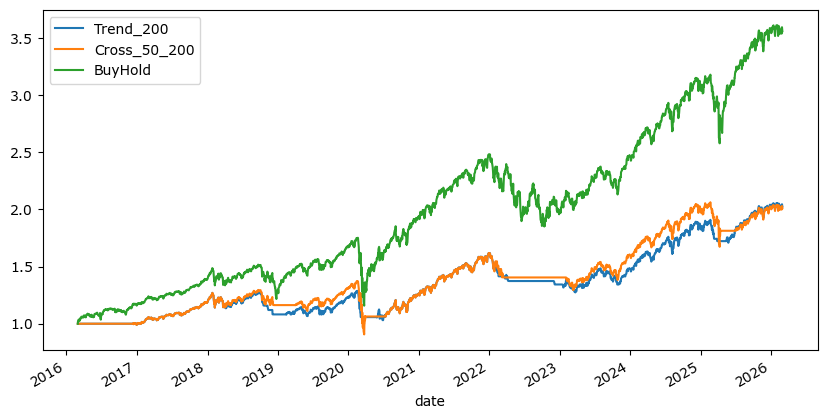

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

curves = pd.DataFrame({k: v["curve"] for k, v in results.items()})
curves["BuyHold"] = equity_curve(sp500["ret"])

curves.dropna().plot(figsize=(10,5))
plt.show()